In [14]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')
import elastic_rods, elastic_knots
import numpy as np, matplotlib.pyplot as plt, time, io, os

from helpers import *
from parametric_curves import *
import py_newton_optimizer

from linkage_vis import LinkageViewer as Viewer, CenterlineViewer
from tri_mesh_viewer import PointCloudViewer, PointCloudMesh

%load_ext autoreload
%autoreload 2

import parallelism
parallelism.set_max_num_tbb_threads(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
file = "../data/L400-r0.2-UpTo9Crossings/4_1/0001.obj"
rod_radius = 0.2
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
centerline = read_nodes_from_file(file)[::4]  # supported formats: obj, txt
pr = define_periodic_rod(centerline, material)
rod_list = elastic_knots.PeriodicRodList([pr])

problemOptions = elastic_knots.ContactProblemOptions()
problemOptions.hasCollisions = True
problemOptions.contactStiffness = 100000
problemOptions.dHat = 2*rod_radius

contactProblem = elastic_knots.ContactProblem(rod_list,problemOptions)

print( f"Gradient length: {len(rod_list.gradient())},DoFs length: {len(rod_list.getDoFs())}")

Gradient length: 401,DoFs length: 401


In [16]:
pathFile = 'pathAB2.npz'
loaded = np.load('Paths/'+pathFile)
path = [loaded[key] for key in loaded.files]
path = path[::4]
pathFile = 'Quater'+pathFile
rod_list.setDoFs(path[0])

In [17]:
view = Viewer(rod_list, width=1024, height=800)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.28, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0),…

In [18]:
def show_path(rod, path, view, wait=0.05):
    for DoFs in path:
        rod.setDoFs(DoFs)
        time.sleep(wait)
        view.update()
show_path(contactProblem,path,view,wait = 0)

def getPathEnergy(path, rod, view):
    path_energy=[]
    for DoFs in path:
        rod.setDoFs(DoFs)
        path_energy.append(rod.energy())
        view.update()
    return path_energy
energy = getPathEnergy(path, contactProblem,view)

def getPathGradient(path, rod):
    path_gradient=[]
    for DoFs in path:
        rod.setDoFs(DoFs)
        path_gradient.append(rod.gradient())
    return path_gradient
path_gradient = getPathGradient(path, contactProblem)

def safe_normalize(v, eps=1e-12):
    norm = np.linalg.norm(v)
    if norm < eps or np.isnan(norm):
        return np.zeros_like(v)
    return v / norm

def getTangent(R_pre, R_next):
    t = R_next - R_pre
    t = safe_normalize(t)
    return np.array(t)

print(np.array(getTangent(path[0],path[2])).shape)

# F_spring = k * (||R_{i+1} - R_i|| - ||R_i - R_{i-1}||) * tangent_i
def getSpringForce(R_pre,R, R_next):
    k = 2
    tangent = getTangent(R_pre, R_next)
    F = k*(np.linalg.norm(R_next-R)-np.linalg.norm(R-R_pre))*tangent
    return np.array(F)
print(np.array(getSpringForce(*path[:3])).shape)

#F_perp =-d_R_{i} + d_R_{i}°tangent_i*tanget_i
def getPerpForce(d_R,R_pre, R_next):
    tangent = getTangent(R_pre, R_next)
    F= (-d_R + (np.dot(d_R,tangent) * tangent))
    return np.array(F)
print(np.array(getPerpForce(path_gradient[0], path[0],path[2])).shape)

def getNEBForce(d_R,R_pre, R, R_next):
    return getPerpForce(d_R,R_pre, R_next) + getSpringForce(R_pre,R, R_next)

print(np.array(getNEBForce(path_gradient[0],*path[:3])).shape)
    

(401,)
(401,)
(401,)
(401,)


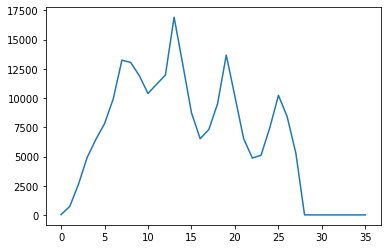

Path energy: 237780.69104863127


In [19]:
path_energy = getPathEnergy(path,contactProblem,view)
plt.plot(range(len(path_energy)),path_energy)

plt.show()
print(f"Path energy: {sum(path_energy)}")

In [22]:
def optimize_rod_path_dofs(R, rod, step_size=0.00002, iterations=10000):
    import time
    import numpy as np

    # Initialize per-knot step sizes
    step_size = np.full(len(R), step_size)
    prevE = np.full(len(R), np.inf)
    start_time = time.time()
    for it in range(iterations + 1):
        totalE = 0.0

        for i in range(1, len(R) - 1):  # skip fixed endpoints
            rod.setDoFs(R[i])
            d_R = rod.gradient()
            F = getNEBForce(d_R, R[i - 1], R[i], R[i + 1])
            E = rod.energy()
            totalE += E
            # Compare force magnitudes to adapt step size per knot
            if E < prevE[i]: 
                step_size[i] *= 1.05  # Gradually increase
            else:
                step_size[i] *= 0.5   # Back off if divergence
    
            step_size[i] = np.clip(step_size[i], 1e-6, 1e-2)

            prevE[i] = E
            
            R[i] += step_size[i] * F  # Gradient ascent — be sure F is negative grad if you want descent

            

        if it % 100 == 0:
            print(f"{it} totalEnergy = {totalE:.6f}, after {(time.time() - start_time):.2f}s")
            print(f"  step_size (min/max): {step_size.min():.2e} / {step_size.max():.2e} mean: {np.mean(step_size)}")

    return R  
new_path = optimize_rod_path_dofs(path, contactProblem, iterations=200000)

0 totalEnergy = 2866.732275, after 0.01s
  step_size (min/max): 2.00e-05 / 2.10e-05 mean: 2.0944444444444445e-05
100 totalEnergy = 2743.073026, after 1.58s
  step_size (min/max): 1.00e-06 / 2.76e-03 mean: 0.0013571511366847703
200 totalEnergy = 2635.312847, after 3.23s
  step_size (min/max): 1.00e-06 / 1.00e-02 mean: 0.003469745385984732
300 totalEnergy = 2540.719556, after 4.80s
  step_size (min/max): 1.00e-06 / 1.00e-02 mean: 0.0030520067192271482
400 totalEnergy = 2465.064965, after 6.46s
  step_size (min/max): 1.00e-06 / 1.00e-02 mean: 0.0037990144724029794
500 totalEnergy = 2398.826239, after 8.33s
  step_size (min/max): 1.00e-06 / 1.00e-02 mean: 0.002971940750029101
600 totalEnergy = 2344.955829, after 10.39s
  step_size (min/max): 1.00e-06 / 1.00e-02 mean: 0.003441288769624765
700 totalEnergy = 2302.666469, after 12.06s
  step_size (min/max): 1.00e-06 / 1.00e-02 mean: 0.0029530477874953965
800 totalEnergy = 2264.766320, after 13.89s
  step_size (min/max): 1.00e-06 / 1.00e-02 mea

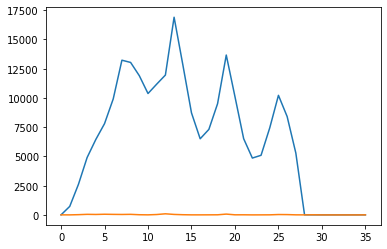

Path old energy: 237643.8998101405, Path new energy: 765.7616927066196
difference:  236878.13811743387


In [65]:
new_path_energy = getPathEnergy(new_path,contactProblem,view)
plt.plot(range(len(path_energy)),path_energy)
plt.plot(range(len(new_path_energy)),new_path_energy)
plt.show()
print(f"Path old energy: {sum(path_energy)}, Path new energy: {sum(new_path_energy)}")
print(f"difference:  {sum(path_energy)- sum(new_path_energy)}")

In [66]:
time.sleep(3)
#show_path(rod_list,path,view)
show_path(rod_list,new_path,view,wait=0.1)   


In [67]:
np.savez('Paths/optimized'+pathFile, *new_path)